# PREPROCESSING

ATTENTION-LSTM Forecasting with VMD Decomposition on ETTh1 Dataset

In this experiment, we use the ETTh1 dataset (Electricity Transformer Temperature, hourly data) to forecast the oil temperature (OT).
We first apply **Variational Mode Decomposition (VMD)** to extract intrinsic mode components (IMFs) from the `OT` series, 
then use an **Attention-based LSTM (Attn-LSTM)** to capture temporal dependencies and focus on informative time steps.



## Import-Params-Read-Visualization

In [84]:
# Parameters
SEQ_LEN = 24  # past 24 hours for each sample
TARGET_COL = 'OT'  # target variable: Oil Temperature
FEATURE_COLS = ['OT']
EPOCHS = 40 
BATCH_SIZE = 32

# VMD parameters
DC = 0              # no DC part imposed
init = 1            # initialize omegas uniformly
tol = 1e-7
K_hat = 8                  # number of VMD modes (tuneable)
alpha_hat = 1705             # VMD alpha (tuneable)
tau_hat = 0.05805898025979961                # VMD tau

LSTM_UNITS = 128
DROPOUT = 0.2
LEARNING_RATE = 1e-3

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.layers import Softmax
from vmdpy import VMD
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Lambda, Input, LSTM, Dense, Dropout,Bidirectional, Layer,LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import random
from tensorflow.keras.layers import Reshape
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.layers import Attention
from tensorflow.keras.layers import Concatenate


In [8]:
save_dir = os.path.expanduser("~/Project/Nested_Attention_BiLSTM_VMD/data/raw")
os.makedirs(save_dir, exist_ok=True)
# Full file path
file_path = os.path.join(save_dir, "ETTh1.csv")
# Load it whenever needed
df = pd.read_csv(file_path)
print(df.head())
df.columns = df.columns.str.strip().str.replace('\ufeff', '')
print(df.columns)
# Ensure datetime type
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
data = df[[TARGET_COL]].values


                  date   HUFL   HULL   MUFL   MULL   LUFL   LULL         OT
0  2016-07-01 00:00:00  5.827  2.009  1.599  0.462  4.203  1.340  30.531000
1  2016-07-01 01:00:00  5.693  2.076  1.492  0.426  4.142  1.371  27.787001
2  2016-07-01 02:00:00  5.157  1.741  1.279  0.355  3.777  1.218  27.787001
3  2016-07-01 03:00:00  5.090  1.942  1.279  0.391  3.807  1.279  25.044001
4  2016-07-01 04:00:00  5.358  1.942  1.492  0.462  3.868  1.279  21.948000
Index(['date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT'], dtype='object')


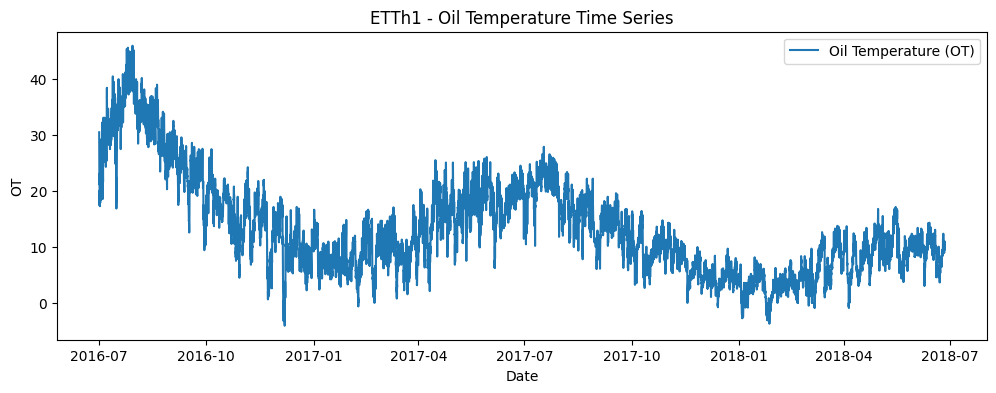

In [9]:
# Visualize
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['OT'], label='Oil Temperature (OT)')
plt.title('ETTh1 - Oil Temperature Time Series')
plt.xlabel('Date')
plt.ylabel('OT')
plt.legend()
plt.show()

## X,Y  and Train_test_split Simple

In [27]:
# =====================================================
# Split Train/Test
# =====================================================
split_idx = int(len(df) * 0.8)
X_train, X_test = df[FEATURE_COLS].values[:split_idx], df[FEATURE_COLS].values[split_idx:]
y_train, y_test = df[TARGET_COL].values[:split_idx].reshape(-1,1), df[TARGET_COL].values[split_idx:].reshape(-1,1)

# =====================================================
# Helper: Create sequences
# =====================================================
def create_sequences_vmd(X, y, seq_len, alpha, tau, K):
    """
    Create sequences of length seq_len and apply VMD on each sequence (X only)
    If alpha=0, tau=0, K=1: no VMD applied (simple sequence)
    """
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        seq_x = X[i:i+seq_len]          # shape: (seq_len, num_features)
        seq_y = y[i+seq_len]            # target aligned after the sequence

        if alpha > 0 and K > 1:
            # Apply VMD on each feature independently
            seq_x_vmd_list = []
            for f in range(seq_x.shape[1]):
                u, _, _ = VMD(seq_x[:, f], alpha, tau, K, DC=0, init=1, tol=1e-7)
                seq_x_vmd_list.append(np.stack(u, axis=1))  # (seq_len, K)
            # Concatenate VMD modes of all features: (seq_len, K*num_features)
            seq_x = np.concatenate(seq_x_vmd_list, axis=1)

        Xs.append(seq_x)
        ys.append(seq_y)

    return np.array(Xs), np.array(ys)

# =====================================================
# Train/Test Sequences
# =====================================================
# VMD sequences
X_train_vmd_seq, y_train_vmd_seq = create_sequences_vmd(X_train, y_train, SEQ_LEN, alpha_hat, tau_hat, K_hat)
X_test_vmd_seq,  y_test_vmd_seq  = create_sequences_vmd(X_test,  y_test,  SEQ_LEN, alpha_hat, tau_hat, K_hat)

# Simple sequences (no VMD)
X_train_simple_seq, y_train_simple_seq = create_sequences_vmd(X_train, y_train, SEQ_LEN, alpha=0, tau=0, K=1)
X_test_simple_seq, y_test_simple_seq   = create_sequences_vmd(X_test, y_test, SEQ_LEN, alpha=0, tau=0, K=1)

# =====================================================
# Scale X sequences
# =====================================================
scaler_x = MinMaxScaler()

# VMD sequences
num_train_seq, seq_len, feat_dim_vmd = X_train_vmd_seq.shape
X_train_vmd_scaled = scaler_x.fit_transform(X_train_vmd_seq.reshape(-1, feat_dim_vmd)).reshape(num_train_seq, seq_len, feat_dim_vmd)
num_test_seq = X_test_vmd_seq.shape[0]
X_test_vmd_scaled = scaler_x.transform(X_test_vmd_seq.reshape(-1, feat_dim_vmd)).reshape(num_test_seq, seq_len, feat_dim_vmd)

# Simple sequences
num_train_seq_s, seq_len_s, feat_dim_s = X_train_simple_seq.shape
X_train_simple_scaled = scaler_x.fit_transform(X_train_simple_seq.reshape(-1, feat_dim_s)).reshape(num_train_seq_s, seq_len_s, feat_dim_s)
num_test_seq_s = X_test_simple_seq.shape[0]
X_test_simple_scaled = scaler_x.transform(X_test_simple_seq.reshape(-1, feat_dim_s)).reshape(num_test_seq_s, seq_len_s, feat_dim_s)

# =====================================================
# Scale y (target) sequences
# =====================================================
scaler_y = MinMaxScaler()
y_train_vmd_scaled = scaler_y.fit_transform(y_train_vmd_seq.reshape(-1,1))
y_test_vmd_scaled  = scaler_y.transform(y_test_vmd_seq.reshape(-1,1))

y_train_simple_scaled = scaler_y.fit_transform(y_train_simple_seq.reshape(-1,1))
y_test_simple_scaled  = scaler_y.transform(y_test_simple_seq.reshape(-1,1))

# =====================================================
# Inverse-transform true y for plotting
# =====================================================
y_test_vmd_true    = scaler_y.inverse_transform(y_test_vmd_scaled)
y_test_simple_true = scaler_y.inverse_transform(y_test_simple_scaled)


/opt/anaconda3/envs/tf-gpu2/lib/python3.11/site-packages/vmdpy/vmdpy.py:114: RuntimeWarning: invalid value encountered in scalar divide
  omega_plus[n+1,k] = np.dot(freqs[T//2:T],(abs(u_hat_plus[n+1, T//2:T, k])**2))/np.sum(abs(u_hat_plus[n+1,T//2:T,k])**2)
/opt/anaconda3/envs/tf-gpu2/lib/python3.11/site-packages/vmdpy/vmdpy.py:112: RuntimeWarning: invalid value encountered in divide
  u_hat_plus[n+1,:,k] = (f_hat_plus - sum_uk - lambda_hat[n,:]/2)/(1+Alpha[k]*(freqs - omega_plus[n,k])**2)


## CUSTOM LAYERS

In [96]:
# =====================================================
# 2️⃣ Bahdanau-style Attention Layer
# =====================================================
class AttentionLayer_Bahdanau(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer_Bahdanau, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            shape=(input_shape[-1], input_shape[-1]),
            initializer="glorot_uniform",
            trainable=True,
            name="att_weight"
        )
        self.b = self.add_weight(
            shape=(input_shape[-1],),
            initializer="zeros",
            trainable=True,
            name="att_bias"
        )
        self.u = self.add_weight(
            shape=(input_shape[-1],),
            initializer="glorot_uniform",
            trainable=True,
            name="context_vector"
        )
        super(AttentionLayer_Bahdanau, self).build(input_shape)

    def call(self, x):
        # x shape: (batch, time_steps, features)
        u_it = tf.tanh(tf.tensordot(x, self.W, axes=1) + self.b)   # (batch, time, features)
        a_it = tf.tensordot(u_it, self.u, axes=1)                  # (batch, time)
        a_it = tf.nn.softmax(a_it, axis=1)                         # (batch, time)
        a_it = tf.expand_dims(a_it, axis=-1)                       # (batch, time, 1)
        weighted_output = x * a_it                                  # (batch, time, features)
        return tf.reduce_sum(weighted_output, axis=1)              # (batch, features)

    def compute_output_shape(self, input_shape):
        # output shape: (batch, features)
        return (input_shape[0], input_shape[2])


def build_attlstm_model(input_shape, lstm1_units=128, lstm2_units=64, dense_units=32, dropout=0.2, lr=1e-3):
    inp = Input(shape=input_shape)
    
    # Encoder LSTM
    x = LSTM(lstm1_units, return_sequences=True)(inp)
    x = Dropout(dropout)(x)
    
    # Attention
    att_out = AttentionLayer_Bahdanau()(x)
    
    # Decoder LSTM 
    x = Reshape((1, lstm1_units))(att_out)
    x = LSTM(lstm2_units, return_sequences=False)(x)
    x = Dropout(dropout)(x)
    
    # Dense layers
    x = Dense(dense_units, activation='relu')(x)
    out = Dense(1)(x)
    
    model = Model(inp, out)
    model.compile(optimizer=Adam(lr), loss='mse', metrics=['mae'])
    return model

# ========================================
# 📌     LSTM + Residual Connection + LayerNorm
# ========================================
class LSTM_residual_norm(Layer):
    def __init__(self, units, dropout=0.1, **kwargs):
        super(LSTM_residual_norm, self).__init__(**kwargs)
        self.units = units
        self.dropout_rate = dropout

        self.lstm = LSTM(units, return_sequences=True)
        self.dropout_layer = Dropout(dropout)
        self.norm = LayerNormalization()

    def build(self, input_shape):
        input_dim = input_shape[-1]    # <-- Detect feature count automatically

        # Projection for residual connection
        self.proj = Dense(self.units)  # input_dim → units

        super().build(input_shape)

    def call(self, x):
        h = self.lstm(x)
        h = self.dropout_layer(h)

        h_res = self.proj(x)   # Now works for any feature dimension

        return self.norm(h + h_res)

# ========================================
# 📌  Attention(Bahdanau) + LSTM + Residual Connection + LayerNorm
# ========================================
def build_att_customlstm_model(input_shape, lstm1_units=128, lstm2_units=64, dense_units=32, dropout=0.2, lr=1e-3):
    inp = Input(shape=input_shape)
    
    # Encoder LSTM
    x = LSTM_residual_norm(lstm1_units)(inp)
    x = Dropout(dropout)(x)
    
    # Attention
    att_out = AttentionLayer_Bahdanau()(x)
    
    # Decoder LSTM 
    x = Reshape((1, lstm1_units))(att_out)
    x = LSTM_residual_norm(lstm2_units)(x)
    x = Dropout(dropout)(x)
    
    # Dense layers
    x = Dense(dense_units, activation='relu')(x)
    out = Dense(1)(x)
    
    model = Model(inp, out)
    model.compile(optimizer=Adam(lr), loss='mse', metrics=['mae'])
    return model
    
# =========================================================
# 📌  Custom Luong Attention
# score = h_t · W · h_s  (dot-product)
# =========================================================
class LuongAttention(Layer):
    def __init__(self, units):
        super(LuongAttention, self).__init__()
        self.Wq = Dense(units)
        self.Wv = Dense(units)

    def call(self, query, value, mask=None):
        # Project both → SAME dimension
        q = self.Wq(query)      # (B, T, units)
        v = self.Wv(value)      # (B, T, units)

        # Dot product score
        score = tf.matmul(q, v, transpose_b=True)  # (B, T, T)

        if mask is not None:
            score += (mask * -1e9)

        # Use tf.nn.softmax (Keras-safe)
        attn_weights = tf.nn.softmax(score, axis=-1)     # (B, T, T)
        context = tf.matmul(attn_weights, v)             # (B, T, units)

        return context

# =========================================================
# 📌  Temporal Attention (per timestep)
# =========================================================
class TemporalAttention(Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        # input_shape = (batch, timesteps, features)
        d = input_shape[-1]

        self.Wt = Dense(self.units, activation='tanh')
        self.vt = Dense(1)

    def call(self, x):
        # score shape -> (batch, timesteps, units)
        h = self.Wt(x)

        # score shape -> (batch, timesteps, 1)
        score = self.vt(h)

        # attention weights
        alpha = tf.nn.softmax(score, axis=1)

        # weighted sum (batch, timesteps, features) -> (batch, features)
        context = tf.reduce_sum(alpha * x, axis=1)

        return context
        
def build_Tattlstm_model(input_shape, lstm1_units=128, lstm2_units=64, dense_units=32, dropout=0.2, lr=1e-3):

    inp = Input(shape=input_shape)

    # Encoder LSTM
    x = LSTM(lstm1_units, return_sequences=True)(inp)
    x = Dropout(dropout)(x)

    # Temporal Attention
    att_out = TemporalAttention(units=lstm1_units)(x)

    # Decoder LSTM - convert context vector to sequence again
    x = Reshape((1, lstm1_units))(att_out)
    x = LSTM(lstm2_units, return_sequences=False)(x)
    x = Dropout(dropout)(x)

    # Dense layers
    x = Dense(dense_units, activation='relu')(x)
    out = Dense(1)(x)

    model = Model(inp, out)
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mse',
        metrics=['mae']
    )
    return model
# =========================================================
# 📌  Cross-Attention (Query from XLSTM, Key/Value from VMD input)
# =========================================================
class CrossAttention(Layer):
    def __init__(self, num_heads=4, key_dim=32):
        super().__init__()
        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)

    def call(self, query, context, mask=None):
        return self.mha(query=query, value=context, key=context, attention_mask=mask)


# =========================================================
# 📌  Causal Masking (prevent future leakage)
# =========================================================
def causal_mask(seq_len):
    mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    return mask[None, None, :, :]



# =========================================================
# 📌  TFT Multi-Head Temporal self-Attention Layer (Keras)
#     this is a valid implementation of the temporal self-attention block inspired by the TFT paper:
#     Multi-head scaled dot-product attention
#     Decoder state as query
#     Encoder outputs as key/value
#     Layer norm + residual
#     Optional causal masking
#     It is simplified (no gating via GRN or VSN), but the attention math is correct and aligned with Transformer/TFT definitions.
# ========================================================= 
class TFTTemporalAttention(Layer):
    def __init__(self, num_heads, model_dim, dropout_rate=0.1,
                 use_mask=False, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.model_dim = model_dim
        self.dropout_rate = dropout_rate
        self.use_mask = use_mask
        
        assert model_dim % num_heads == 0
        self.head_dim = model_dim // num_heads

        self.Wq = Dense(model_dim)
        self.Wk = Dense(model_dim)
        self.Wv = Dense(model_dim)
        self.Wo = Dense(model_dim)

        self.layernorm = LayerNormalization(epsilon=1e-6)
        self.dropout = Dropout(dropout_rate)

    def build(self, input_shape):
        self.Wq.build(input_shape[0])
        self.Wk.build(input_shape[0])
        self.Wv.build(input_shape[0])
        self.Wo.build((None, None, self.model_dim))
        self.layernorm.build((None, None, self.model_dim))
        self.built = True

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1,
                           self.num_heads, self.head_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs, training=None):
        encoder_out, decoder_state = inputs

        batch_size = tf.shape(encoder_out)[0]

        dec_expanded = tf.repeat(
            tf.expand_dims(decoder_state, axis=1),
            repeats=tf.shape(encoder_out)[1],
            axis=1
        )

        Q = self.Wq(dec_expanded)
        K = self.Wk(encoder_out)
        V = self.Wv(encoder_out)

        Q = self.split_heads(Q, batch_size)
        K = self.split_heads(K, batch_size)
        V = self.split_heads(V, batch_size)

        score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.cast(tf.sqrt(float(self.head_dim)), tf.float32)
        score = score / scale

        if self.use_mask:
            T = tf.shape(encoder_out)[1]
            mask = tf.linalg.band_part(tf.ones((T, T)), -1, 0)
            mask = 1e-9 * (1 - mask)
            score += mask

        alpha = tf.nn.softmax(score, axis=-1)
        att_out = tf.matmul(alpha, V)

        att_out = tf.transpose(att_out, perm=[0, 2, 1, 3])
        att_out = tf.reshape(att_out,
                             (batch_size, -1, self.model_dim))

        out = self.Wo(att_out)

        # residual: input must have same dim
        out = self.layernorm(out)

        return out


def build_TFTattlstm_model(input_shape, lstm1_units=100, lstm2_units=100,
                            dense_units=32, num_heads=8, model_dim=64, dropout=0.1):

    # -------------------------
    # 0. Input
    # -------------------------
    encoder_inputs = Input(shape=input_shape)

    # -------------------------
    # 1. Encoder LSTM
    # -------------------------
    enc_out = LSTM(lstm1_units, return_sequences=True)(encoder_inputs)
    enc_out = Dropout(dropout)(enc_out)
    enc_out = LayerNormalization()(enc_out)
    enc_out = Dense(model_dim)(enc_out)  # project to model_dim
    enc_out = LayerNormalization()(enc_out)

    # -------------------------
    # 1b. Bahdanau Attention applied to encoder
    # -------------------------
    bahdanau_att_1 = AttentionLayer_Bahdanau()(enc_out)
    bahdanau_att_enc = Lambda(lambda x: tf.expand_dims(x, axis=1))(bahdanau_att_1)

    # -------------------------
    # 2. Decoder LSTM
    # -------------------------
    dec_out = LSTM(lstm2_units, return_sequences=True)(bahdanau_att_enc)
    dec_out = Dropout(dropout)(dec_out)
    dec_out = Dense(model_dim)(dec_out)  # ensure same feature dimension
    dec_out = LayerNormalization()(dec_out)

    # Bahdanau attention over decoder
    bahdanau_att_dec = AttentionLayer_Bahdanau()(dec_out)  # shape: (batch, model_dim)

    # -------------------------
    # 3. TFT Multi-Head Attention Stack
    # -------------------------
    att_layer = TFTTemporalAttention(num_heads=num_heads, model_dim=model_dim)
    att_out = att_layer([bahdanau_att_enc, bahdanau_att_dec])

    # -------------------------
    # 4. Dense output
    # -------------------------
    x = Bidirectional(LSTM(dense_units))(att_out)
    output = Dense(1)(x)

    # -------------------------
    # 5. Model compile
    # -------------------------
    model = Model(encoder_inputs, output)
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])

    return model


# AttLSTM+VMD

📚 Reference for Attention Mechanism

**Bahdanau, Dzmitry; Cho, Kyunghyun; Bengio, Yoshua (2014).**
*Neural Machine Translation by Jointly Learning to Align and Translate.*
arXiv:1409.0473

🔗 [https://arxiv.org/abs/1409.0473](https://arxiv.org/abs/1409.0473)


📚 Reference for VMD (Variational Mode Decomposition)

**Dragomiretskiy, K., & Zosso, D. (2014).**
*Variational Mode Decomposition.*
IEEE Transactions on Signal Processing, 62(3), 531–544.

🔗 [https://doi.org/10.1109/TSP.2013.2288675](https://doi.org/10.1109/TSP.2013.2288675)
🔗 [https://arxiv.org/abs/1406.5858](https://arxiv.org/abs/1406.5858)



Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 24, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 24, 132)        │        74,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 24, 132)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer__bahdanau_4     │ (None, 132)            │        17,688 │
│ (AttentionLayer_Bahdanau)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 1, 132)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 132)            │       139,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 132)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 64)             │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 240,633 (939.97 KB)

 Trainable params: 240,633 (939.97 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0071 - mae: 0.0528 - val_loss: 0.0010 - val_mae: 0.0245
Epoch 2/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0019 - mae: 0.0326 - val_loss: 5.9187e-04 - val_mae: 0.0177
Epoch 3/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0014 - mae: 0.0288 - val_loss: 4.9151e-04 - val_mae: 0.0163
Epoch 4/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0013 - mae: 0.0273 - val_loss: 4.6984e-04 - val_mae: 0.0157
Epoch 5/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0012 - mae: 0.0264 - val_loss: 4.4683e-04 - val_mae: 0.0154
Epoch 6/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0011 - mae: 0.0248 - val_loss: 6.6426e-04 - val_mae: 0.0198
Epoch 7/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0011 - mae: 0.0242 - val_loss: 9.7507e-04 - val_mae: 0.0257
Epoch 8/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 9.9860e-04 - mae: 0.0234 - val_loss: 5.4378e-04 - val_mae: 0.0183
Epoch 9/30
218/218

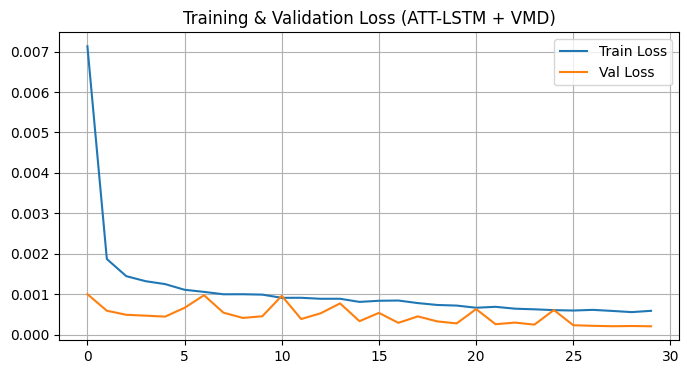

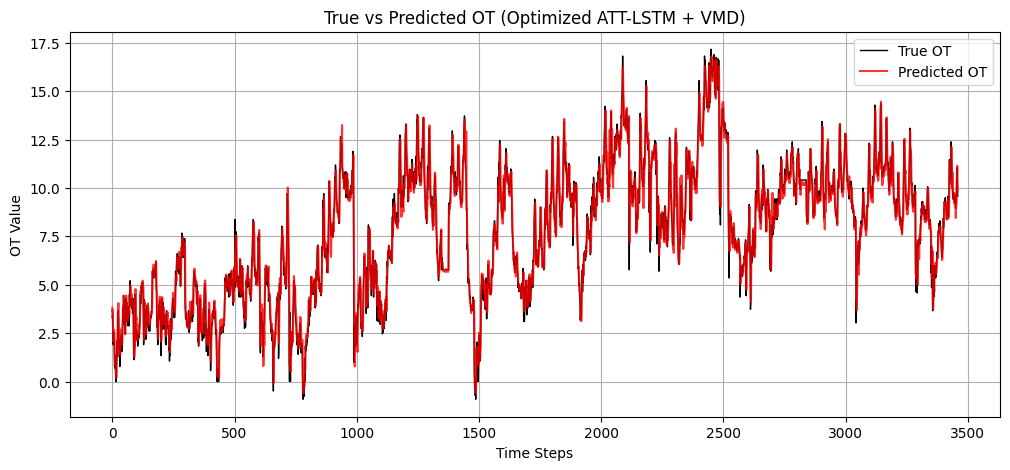

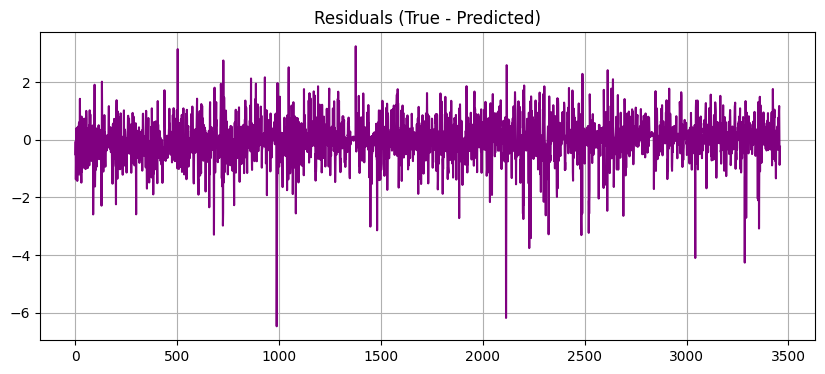

Total Area = 1759.1144160777333
Area + = 874.4685856252918
Area - = -884.6458304524416


In [28]:
model_build_attlstm_model = build_attlstm_model(
    input_shape=(SEQ_LEN, X_train_vmd_scaled.shape[2]),
    lstm1_units=132,
    lstm2_units=132,
    dense_units=64
)
model_build_attlstm_model.summary()

history_attlstm_vmd = model_build_attlstm_model.fit(
    X_train_vmd_scaled, y_train_vmd_scaled,
    validation_data=(X_test_vmd_scaled, y_test_vmd_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict and inverse-transform
y_pred_attlstm_vmd_scaled = model_build_attlstm_model.predict(X_test_vmd_scaled)
y_pred_attlstm_vmd_true = scaler_y.inverse_transform(y_pred_attlstm_vmd_scaled)

# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_attlstm_vmd.history['loss'], label='Train Loss')
plt.plot(history_attlstm_vmd.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (ATT-LSTM + VMD)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_vmd_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_attlstm_vmd_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (Optimized ATT-LSTM + VMD)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_vmd_true - y_pred_attlstm_vmd_true
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()

res = y_test_vmd_true.squeeze() - y_pred_attlstm_vmd_true.squeeze()
area_total_attlstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_attlstm_vmd)
area_positive_attlstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_attlstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_attlstm_vmd)
print("Area - =", area_negative_attlstm_vmd)

# TAttLSTM+VMD
Temporary Attention + lstm + vmd
📚 Reference for Attention Mechanism

**Bahdanau, Dzmitry; Cho, Kyunghyun; Bengio, Yoshua (2014).**
*Neural Machine Translation by Jointly Learning to Align and Translate.*
arXiv:1409.0473

🔗 [https://arxiv.org/abs/1409.0473](https://arxiv.org/abs/1409.0473)


📚 Reference for VMD (Variational Mode Decomposition)

**Dragomiretskiy, K., & Zosso, D. (2014).**
*Variational Mode Decomposition.*
IEEE Transactions on Signal Processing, 62(3), 531–544.

🔗 [https://doi.org/10.1109/TSP.2013.2288675](https://doi.org/10.1109/TSP.2013.2288675)
🔗 [https://arxiv.org/abs/1406.5858](https://arxiv.org/abs/1406.5858)



Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 24, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 24, 132)        │        74,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 24, 132)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ temporal_attention_1            │ (None, 132)            │        17,689 │
│ (TemporalAttention)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 1, 132)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 132)            │       139,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 132)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 64)             │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 240,634 (939.98 KB)

 Trainable params: 240,634 (939.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0087 - mae: 0.0575 - val_loss: 7.8014e-04 - val_mae: 0.0204
Epoch 2/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0018 - mae: 0.0327 - val_loss: 6.2639e-04 - val_mae: 0.0183
Epoch 3/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0017 - mae: 0.0309 - val_loss: 5.0273e-04 - val_mae: 0.0163
Epoch 4/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0013 - mae: 0.0272 - val_loss: 4.8104e-04 - val_mae: 0.0160
Epoch 5/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0013 - mae: 0.0265 - val_loss: 4.8376e-04 - val_mae: 0.0163
Epoch 6/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0011 - mae: 0.0249 - val_loss: 4.2135e-04 - val_mae: 0.0149
Epoch 7/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0012 - mae: 0.0256 - val_loss: 4.4879e-04 - val_mae: 0.0153
Epoch 8/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0010 - mae: 0.0237 - val_loss: 0.0011 - val_mae: 0.0287
Epoch 9/30
218/218 ━━━━━

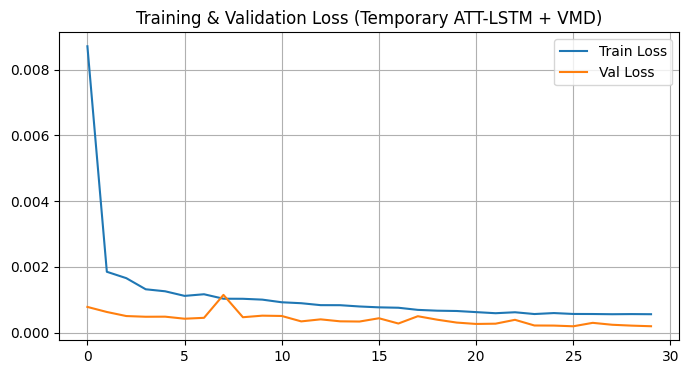

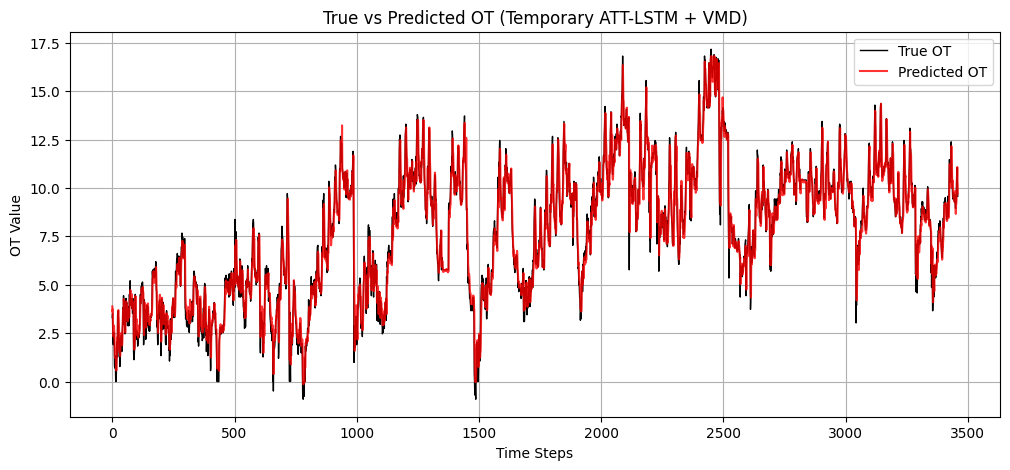

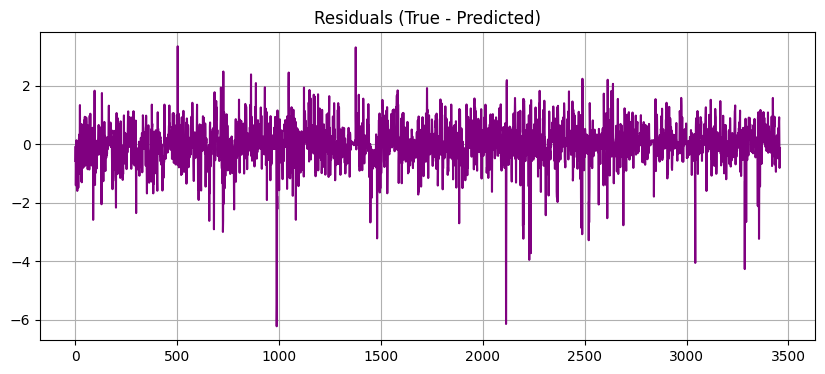

Total Area = 1669.1860116915782
Area + = 853.0731323920199
Area - = -816.112879299558


In [29]:
model_build_Tattlstm_model = build_Tattlstm_model(
    input_shape=(SEQ_LEN, X_train_vmd_scaled.shape[2]),
    lstm1_units=132,
    lstm2_units=132,
    dense_units=64
)
model_build_Tattlstm_model.summary()

history_Tattlstm_vmd = model_build_Tattlstm_model.fit(
    X_train_vmd_scaled, y_train_vmd_scaled,
    validation_data=(X_test_vmd_scaled, y_test_vmd_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict and inverse-transform
y_pred_Tattlstm_vmd_scaled = model_build_Tattlstm_model.predict(X_test_vmd_scaled)
y_pred_Tattlstm_vmd_true = scaler_y.inverse_transform(y_pred_Tattlstm_vmd_scaled)

# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_Tattlstm_vmd.history['loss'], label='Train Loss')
plt.plot(history_Tattlstm_vmd.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (Temporary ATT-LSTM + VMD)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_vmd_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_Tattlstm_vmd_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (Temporary ATT-LSTM + VMD)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_vmd_true - y_pred_Tattlstm_vmd_true
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()

res = y_test_vmd_true.squeeze() - y_pred_Tattlstm_vmd_true.squeeze()
area_total_Tattlstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_Tattlstm_vmd)
area_positive_Tattlstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_Tattlstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_Tattlstm_vmd)
print("Area - =", area_negative_Tattlstm_vmd)

# TFT Multi-Head Temporal self-Attention lstm

Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_42      │ (None, 24, 8)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_115 (LSTM)     │ (None, 24, 64)    │     18,688 │ input_layer_42[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_96          │ (None, 24, 64)    │          0 │ lstm_115[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 64)    │        128 │ dropout_96[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_338 (Dense)   │ (None, 24, 64)    │      4,160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 64)    │        128 │ dense_338[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 64)        │      4,224 │ layer_normalizat… │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_37 (Lambda)  │ (None, 1, 64)     │          0 │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_116 (LSTM)     │ (None, 1, 64)     │     33,024 │ lambda_37[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_97          │ (None, 1, 64)     │          0 │ lstm_116[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_339 (Dense)   │ (None, 1, 64)     │      4,160 │ dropout_97[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 64)     │        128 │ dense_339[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 64)        │      4,224 │ layer_normalizat… │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tft_temporal_atten… │ (None, None, 64)  │     16,768 │ lambda_37[0][0],  │
│ (TFTTemporalAttent… │                   │            │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_22    │ (None, 16)        │      4,672 │ tft_temporal_att… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_344 (Dense)   │ (None, 1)         │         17 │ bidirectional_22… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 90,321 (352.82 KB)

 Trainable params: 90,321 (352.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 0.0030 - mae: 0.0372 - val_loss: 5.2859e-04 - val_mae: 0.0166
Epoch 2/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0013 - mae: 0.0273 - val_loss: 5.9793e-04 - val_mae: 0.0185
Epoch 3/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0012 - mae: 0.0264 - val_loss: 8.7557e-04 - val_mae: 0.0244
Epoch 4/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0011 - mae: 0.0248 - val_loss: 6.4902e-04 - val_mae: 0.0205
Epoch 5/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0011 - mae: 0.0249 - val_loss: 4.7335e-04 - val_mae: 0.0167
Epoch 6/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 9.7944e-04 - mae: 0.0234 - val_loss: 9.5426e-04 - val_mae: 0.0256
Epoch 7/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 8.9208e-04 - mae: 0.0224 - val_loss: 5.5231e-04 - val_mae: 0.0181
Epoch 8/40
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 8.2169e-04 - mae: 0.0215 - val_loss: 6.8805e-04 - val_mae: 0.0223
Epo

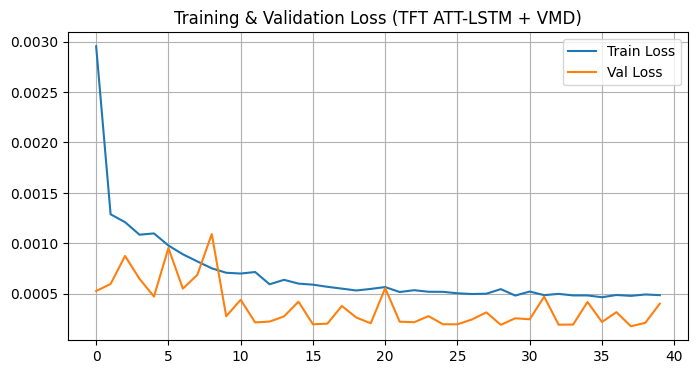

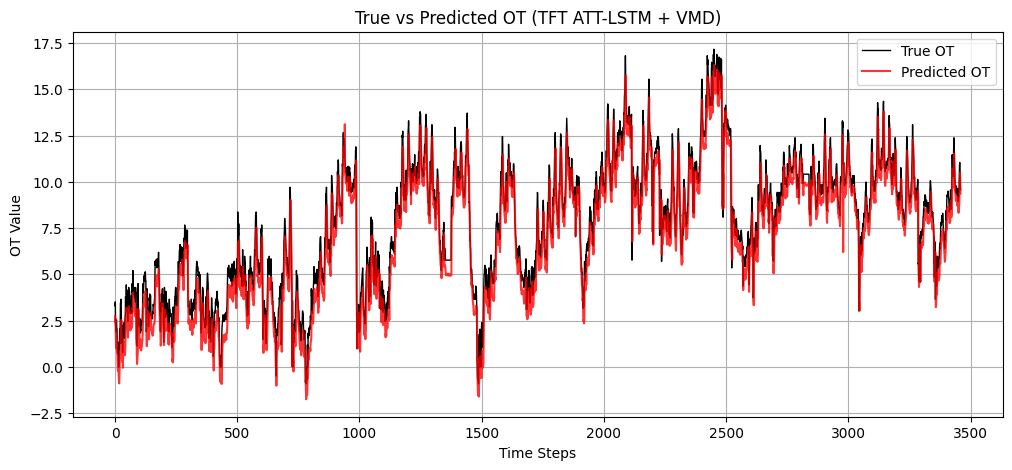

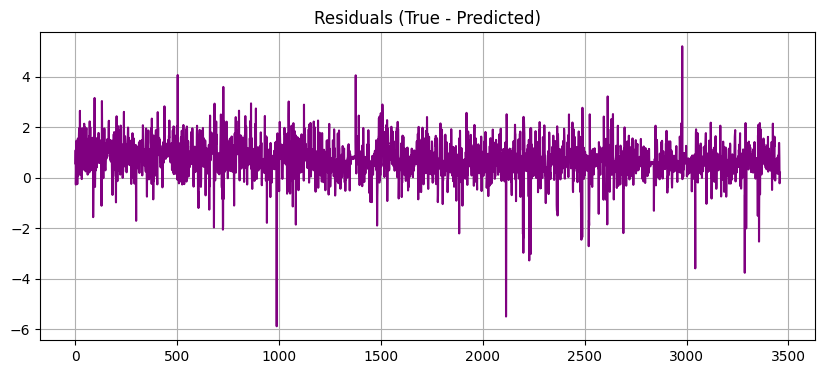

Total Area = 1700.914352953434
Area + = 881.9630869533873
Area - = -818.9512660000466


In [97]:
model_build_TFTattlstm_model = build_TFTattlstm_model(
    input_shape=(SEQ_LEN, X_train_vmd_scaled.shape[2]),
    lstm1_units=64,
    lstm2_units=64,
    dense_units=8,
    num_heads=8,
    model_dim=64,
    dropout=0.1
)

model_build_TFTattlstm_model.summary()

history_TFTattlstm_vmd = model_build_TFTattlstm_model.fit(
    X_train_vmd_scaled, y_train_vmd_scaled,
    validation_data=(X_test_vmd_scaled, y_test_vmd_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict and inverse-transform
y_pred_TFTattlstm_vmd_scaled = model_build_TFTattlstm_model.predict(X_test_vmd_scaled)
# Flatten to 2D: (num_samples*time_steps, 1)
y_pred_flat = y_pred_TFTattlstm_vmd_scaled.reshape(-1, 1)
# Inverse transform
y_pred_TFTattlstm_vmd_true = scaler_y.inverse_transform(y_pred_flat)

# Optional: reshape back to (num_samples, time_steps)
y_pred_TFTattlstm_vmd_true = y_pred_TFTattlstm_vmd_true.reshape(y_pred_TFTattlstm_vmd_scaled.shape[0],
                                                                y_pred_TFTattlstm_vmd_scaled.shape[1])
# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_TFTattlstm_vmd.history['loss'], label='Train Loss')
plt.plot(history_TFTattlstm_vmd.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (TFT ATT-LSTM + VMD)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_vmd_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_TFTattlstm_vmd_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (TFT ATT-LSTM + VMD)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_vmd_true - y_pred_TFTattlstm_vmd_true
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()


res = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
area_total_TFTattlstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_TFTattlstm_vmd)
area_positive_TFTattlstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_TFTattlstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_TFTattlstm_vmd)
print("Area - =", area_negative_TFTattlstm_vmd)

# AttnLSTM+SIMPLE

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 24, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 24, 122)        │        60,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 24, 122)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer__bahdanau_6     │ (None, 122)            │        15,128 │
│ (AttentionLayer_Bahdanau)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 1, 122)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 122)            │       119,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 122)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 64)             │         7,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 203,137 (793.50 KB)

 Trainable params: 203,137 (793.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0087 - mae: 0.0582 - val_loss: 0.0013 - val_mae: 0.0266
Epoch 2/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0027 - mae: 0.0398 - val_loss: 0.0011 - val_mae: 0.0249
Epoch 3/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0026 - mae: 0.0388 - val_loss: 0.0011 - val_mae: 0.0243
Epoch 4/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0024 - mae: 0.0374 - val_loss: 9.5731e-04 - val_mae: 0.0231
Epoch 5/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0017 - mae: 0.0312 - val_loss: 5.4128e-04 - val_mae: 0.0173
Epoch 6/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0013 - mae: 0.0269 - val_loss: 4.0805e-04 - val_mae: 0.0146
Epoch 7/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0011 - mae: 0.0244 - val_loss: 5.5955e-04 - val_mae: 0.0181
Epoch 8/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 9.1826e-04 - mae: 0.0225 - val_loss: 2.8291e-04 - val_mae: 0.0118
Epoch 9/30
218/218 ━━━━━

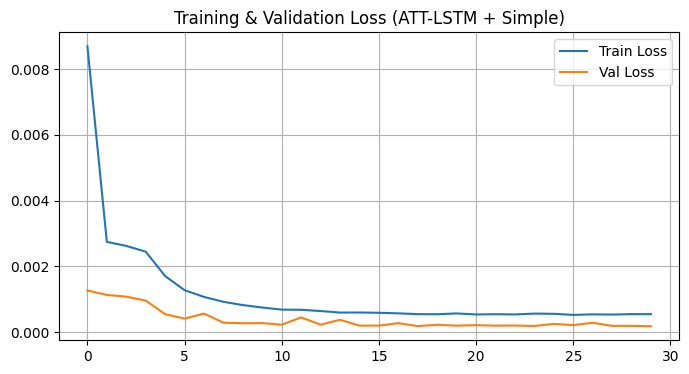

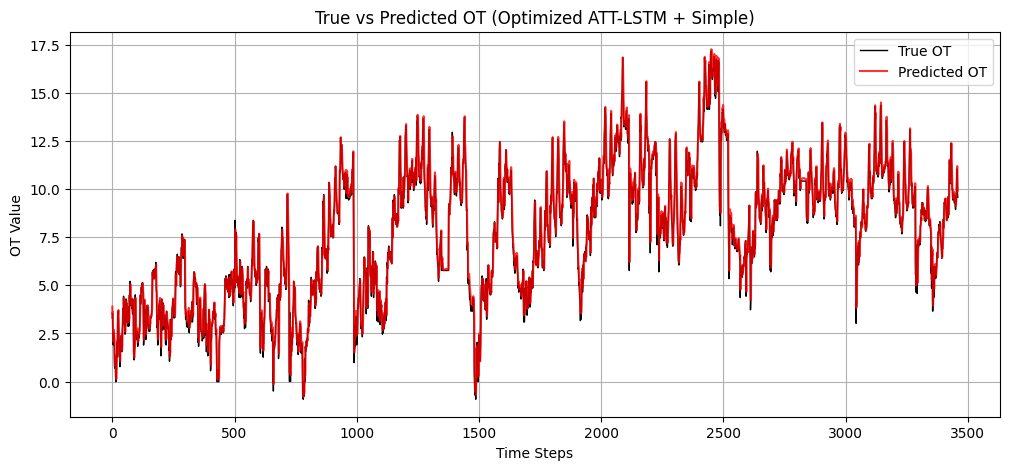

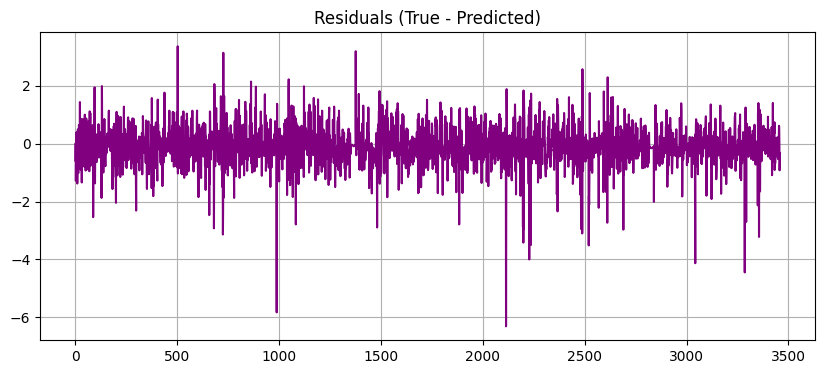

Total Area = 1584.2894788298286
Area + = 638.187942075311
Area - = -946.1015367545178


In [31]:
model_build_attlstm_model = build_attlstm_model(
    input_shape=(SEQ_LEN, X_train_simple_scaled.shape[-1]),
    lstm1_units=122,
    lstm2_units=122,
    dense_units=64
)

model_build_attlstm_model.summary()

history_attlstm_simple = model_build_attlstm_model.fit(
    X_train_simple_scaled, y_train_simple_scaled,
    validation_data=(X_test_simple_scaled, y_test_simple_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Predict (inverse-transform from original OT scaling)
y_pred_attlstm_simple_ga_scaled = model_build_attlstm_model.predict(X_test_simple_scaled)
y_pred_attlstm_simple_true = scaler_y.inverse_transform(y_pred_attlstm_simple_ga_scaled)

# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8,4))
plt.plot(history_attlstm_simple.history['loss'], label='Train Loss')
plt.plot(history_attlstm_simple.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss (ATT-LSTM + Simple)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_simple_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_attlstm_simple_true, label='Predicted OT', color='red', alpha=0.8)
plt.title('True vs Predicted OT (Optimized ATT-LSTM + Simple)')
plt.xlabel('Time Steps'); plt.ylabel('OT Value')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(10,4))
residuals = y_test_simple_true - y_pred_attlstm_simple_true
plt.plot(residuals, color='purple')
plt.title('Residuals (True - Predicted)')
plt.grid(True); plt.show()

res = y_test_simple_true.squeeze() - y_pred_attlstm_simple_true.squeeze()
area_total_attlstm_simple = np.trapezoid(np.abs(res))
print("Total Area =", area_total_attlstm_simple)
area_positive_attlstm_simple = np.trapezoid(np.clip(res, 0, None))
area_negative_attlstm_simple = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_attlstm_simple)
print("Area - =", area_negative_attlstm_simple)

# BidirectionalLSTM_SIMPLE

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 24, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 24, 200)        │        87,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 24, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 100)            │       120,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 207,701 (811.33 KB)

 Trainable params: 207,701 (811.33 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0049 - mae: 0.0445 - val_loss: 4.5585e-04 - val_mae: 0.0159
Epoch 2/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0014 - mae: 0.0288 - val_loss: 3.9822e-04 - val_mae: 0.0149
Epoch 3/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0012 - mae: 0.0266 - val_loss: 2.7493e-04 - val_mae: 0.0118
Epoch 4/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0012 - mae: 0.0254 - val_loss: 2.9189e-04 - val_mae: 0.0125
Epoch 5/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0010 - mae: 0.0236 - val_loss: 2.2546e-04 - val_mae: 0.0105
Epoch 6/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 9.8664e-04 - mae: 0.0233 - val_loss: 4.2708e-04 - val_mae: 0.0167
Epoch 7/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 9.1718e-04 - mae: 0.0225 - val_loss: 2.3164e-04 - val_mae: 0.0109
Epoch 8/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 8.7648e-04 - mae: 0.0219 - val_loss: 4.3611e-04 - val_mae: 0.0175
Epoc

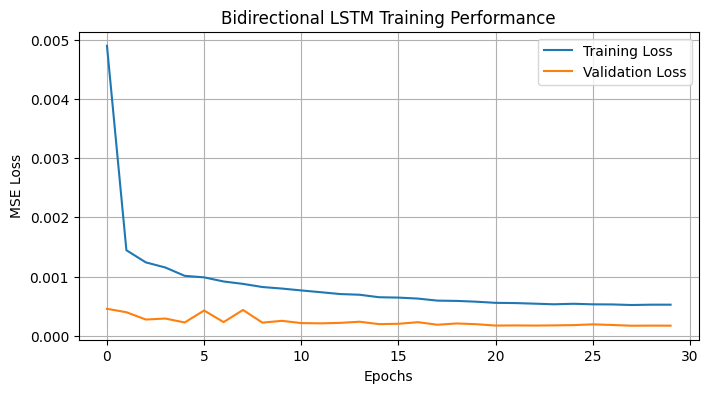

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


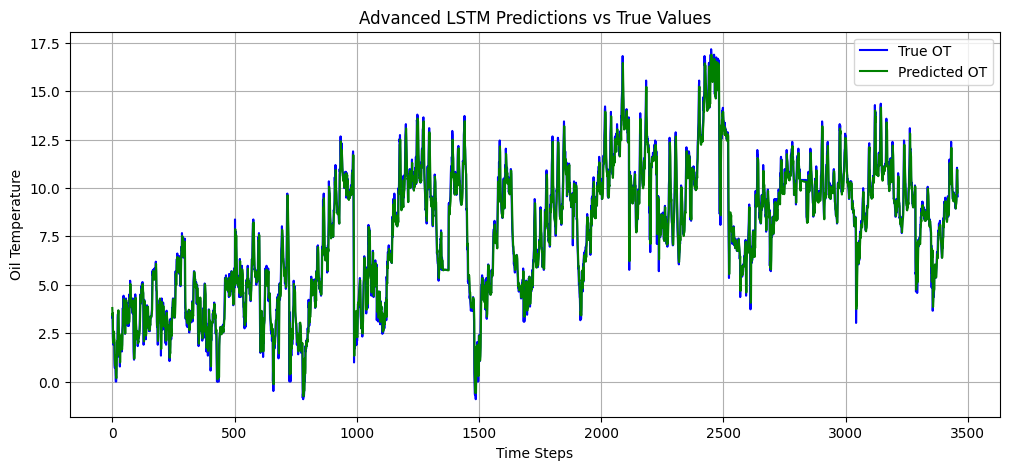

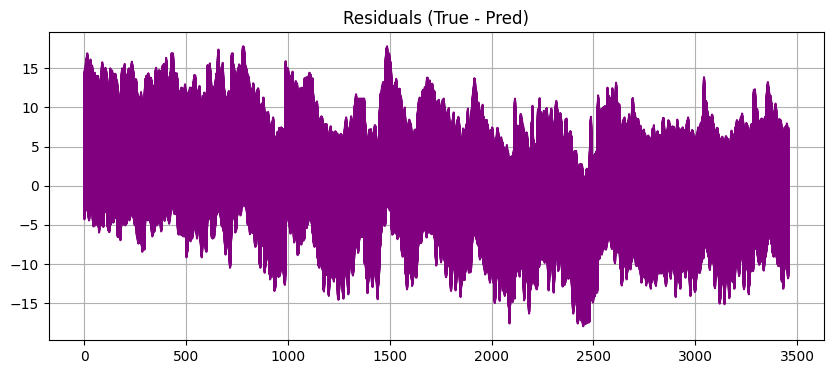

Total Area = 1555.4712009336802
Area + = 870.3099254295239
Area - = -685.1612755041563


In [32]:
# ---------------------------
# 5. Build Bidirectional_LSTM model
# ---------------------------
def build_Bidirectional_lstm_model(input_shape, units=LSTM_UNITS, dropout=DROPOUT):
    inp = Input(shape=input_shape)
    x = Bidirectional(LSTM(units, return_sequences=True))(inp)
    x = Dropout(dropout)(x)
    x = LSTM(units, return_sequences=False)(x)
    x = Dropout(dropout)(x)
    out = Dense(1)(x)
    model = Model(inp, out)
    model.compile(optimizer=Adam(LEARNING_RATE), loss='mse', metrics=['mae'])
    return model

Bidirectional_lstm = build_Bidirectional_lstm_model((SEQ_LEN, K_hat),100)
Bidirectional_lstm.summary()

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history_Bidirectional_lstm_simple = Bidirectional_lstm.fit(
    X_train_simple_scaled, y_train_simple_scaled,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test_simple_scaled, y_test_simple_scaled),
    callbacks=[early_stop],
    verbose=1
)

# Plot training history
plt.figure(figsize=(8, 4))
plt.plot(history_Bidirectional_lstm_simple.history['loss'], label='Training Loss')
plt.plot(history_Bidirectional_lstm_simple.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Bidirectional LSTM Training Performance')
plt.legend()
plt.grid(True)
plt.show()

# Make predictions
y_pred_scaled_Bidirectional_lstm = Bidirectional_lstm.predict(X_test_simple_scaled)
y_pred_Bidirectional_lstm_simple_true = scaler_y.inverse_transform(y_pred_scaled_Bidirectional_lstm.reshape(-1, 1)).flatten()

# Plot predictions vs true values
plt.figure(figsize=(12, 5))
plt.plot(y_test_simple_true, label='True OT', color='blue')
plt.plot(y_pred_Bidirectional_lstm_simple_true, label='Predicted OT', color='green')
plt.xlabel('Time Steps')
plt.ylabel('Oil Temperature')
plt.title('Advanced LSTM Predictions vs True Values')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
res = y_pred_Bidirectional_lstm_simple_true - y_test_simple_true
plt.plot(res, color='purple')
plt.title('Residuals (True - Pred)')
plt.grid(True)
plt.show()

res = y_test_simple_true.squeeze() - y_pred_Bidirectional_lstm_simple_true
area_total_Bidirectional_lstm_simple = np.trapezoid(np.abs(res))
print("Total Area =", area_total_Bidirectional_lstm_simple)
area_positive_Bidirectional_lstm_simple = np.trapezoid(np.clip(res, 0, None))
area_negative_Bidirectional_lstm_simple = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_Bidirectional_lstm_simple)
print("Area - =", area_negative_Bidirectional_lstm_simple)

# LSTM_VMD

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 24, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 24, 128)        │        70,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_28 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,857 (788.50 KB)

 Trainable params: 201,857 (788.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0043 - mae: 0.0431 - val_loss: 5.2045e-04 - val_mae: 0.0176
Epoch 2/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0015 - mae: 0.0297 - val_loss: 4.2390e-04 - val_mae: 0.0157
Epoch 3/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0014 - mae: 0.0283 - val_loss: 4.8276e-04 - val_mae: 0.0167
Epoch 4/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0012 - mae: 0.0261 - val_loss: 4.2155e-04 - val_mae: 0.0154
Epoch 5/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0011 - mae: 0.0247 - val_loss: 2.6279e-04 - val_mae: 0.0114
Epoch 6/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 9.9422e-04 - mae: 0.0235 - val_loss: 4.0720e-04 - val_mae: 0.0162
Epoch 7/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 9.2936e-04 - mae: 0.0225 - val_loss: 2.4676e-04 - val_mae: 0.0111
Epoch 8/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 8.6729e-04 - mae: 0.0220 - val_loss: 3.2569e-04 - val_mae: 0.0142
Epoch 

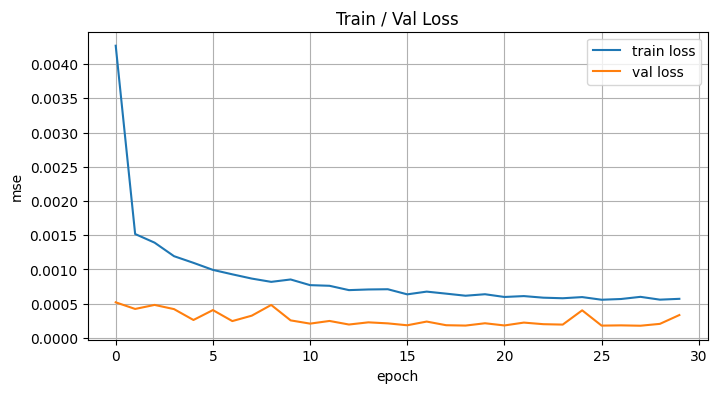

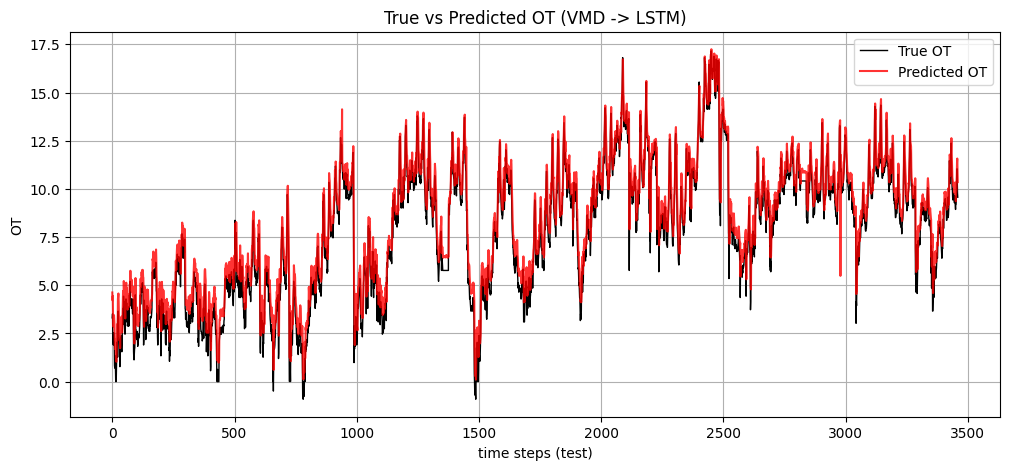

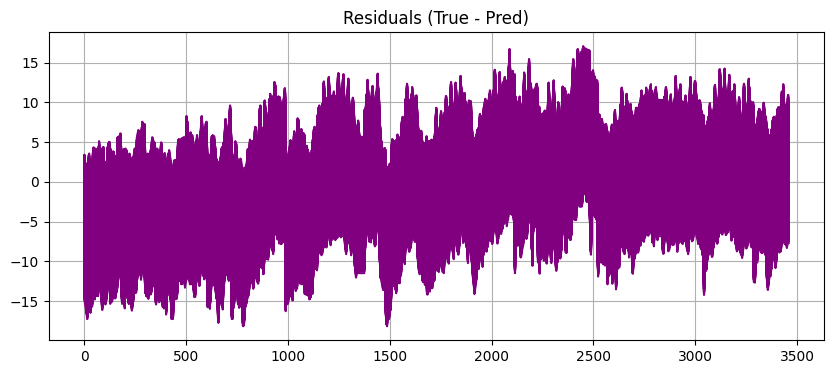

Total Area = 2510.5128560066214
Area + = 199.9757432341578
Area - = -2310.5371127724634


In [33]:
# ---------------------------
# 5. Build LSTM model
# ---------------------------
def build_lstm_model(input_shape, units=LSTM_UNITS, dropout=DROPOUT):
    inp = Input(shape=input_shape)
    x = LSTM(units, return_sequences=True)(inp)
    x = Dropout(dropout)(x)
    x = LSTM(units, return_sequences=False)(x)
    x = Dropout(dropout)(x)
    out = Dense(1)(x)
    model = Model(inp, out)
    model.compile(optimizer=Adam(LEARNING_RATE), loss='mse', metrics=['mae'])
    return model

model_lstm_model= build_lstm_model((SEQ_LEN, K_hat),128)
model_lstm_model.summary()

# ---------------------------
# 6. Train
# ---------------------------
history_lstm_vmd = model_lstm_model.fit(
    X_train_vmd_scaled, y_train_vmd_scaled,
    validation_data=(X_test_vmd_scaled, y_test_vmd_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# ---------------------------
# 7. Predict & inverse-transform
# ---------------------------
y_pred_lstm_vmd_scaled = model_lstm_model.predict(X_test_vmd_scaled)
y_pred_lstm_vmd_true = scaler_y.inverse_transform(y_pred_lstm_vmd_scaled).flatten()

# ---------------------------
# 9. Plots
# ---------------------------
plt.figure(figsize=(8,4))
plt.plot(history_lstm_vmd.history['loss'], label='train loss')
plt.plot(history_lstm_vmd.history['val_loss'], label='val loss')
plt.xlabel('epoch'); plt.ylabel('mse'); plt.legend(); plt.grid(True)
plt.title('Train / Val Loss')
plt.show()

plt.figure(figsize=(12,5))
plt.plot(y_test_vmd_true, label='True OT', color='black', linewidth=1)
plt.plot(y_pred_lstm_vmd_true, label='Predicted OT', color='red', alpha=0.8)
plt.xlabel('time steps (test)')
plt.ylabel('OT')
plt.title('True vs Predicted OT (VMD -> LSTM)')
plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
res = y_test_vmd_true - y_pred_lstm_vmd_true 
plt.plot(res, color='purple')
plt.title('Residuals (True - Pred)')
plt.grid(True)
plt.show()

res = y_test_vmd_true.squeeze() - y_pred_lstm_vmd_true
area_total_lstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_lstm_vmd)
area_positive_lstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_lstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_lstm_vmd)
print("Area - =", area_negative_lstm_vmd)

# Compare Models

In [94]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def compute_metrics(y_true, y_pred):
    min_len = min(len(y_true), len(y_pred))
    y_true, y_pred = y_true[:min_len], y_pred[:min_len]
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2

# Compute metrics
mse_Attlstm_vmd, rmse_Attlstm_vmd, mae_Attlstm_vmd, r2_attlstm_vmd = compute_metrics(y_pred_attlstm_vmd_true, y_test_vmd_true)
mse_TAttlstm_vmd, rmse_TAttlstm_vmd, mae_TAttlstm_vmd, r2_Tattlstm_vmd = compute_metrics(y_pred_Tattlstm_vmd_true, y_test_vmd_true)
mse_TFTAttlstm_vmd, rmse_TFTAttlstm_vmd, mae_TFTAttlstm_vmd, r2_TFTattlstm_vmd = compute_metrics(y_pred_TFTattlstm_vmd_true, y_test_vmd_true)
mse_Lstm_Bidirectional_simple, rmse_Lstm_Bidirectional_simple, mae_Lstm_Bidirectional_simple, r2_Lstm_Bidirectional_simple = compute_metrics(y_pred_Bidirectional_lstm_simple_true, y_test_simple_true)
mse_Attlstm_simple, rmse_Attlstm_simple, mae_Attlstm_simple, r2_attlstm_simple = compute_metrics(y_pred_attlstm_simple_true, y_test_simple_true)
mse_Lstm_vmd, rmse_Lstm_vmd, mae_Lstm_vmd, r2_Lstm_vmd = compute_metrics(y_pred_lstm_vmd_true, y_test_vmd_true)

# Print comparison
print("📈 Model Performance Comparison")
print(f"ATT-LSTM-VMD: MSE={mse_Attlstm_vmd:.4f}, RMSE={rmse_Attlstm_vmd:.4f}, MAE={mae_Attlstm_vmd:.4f}, R²={r2_attlstm_vmd:.4f}, total_area={area_total_attlstm_vmd:.4f}")
print(f"TATT-LSTM-VMD: MSE={mse_TAttlstm_vmd:.4f}, RMSE={rmse_TAttlstm_vmd:.4f}, MAE={mae_TAttlstm_vmd:.4f}, R²={r2_Tattlstm_vmd:.4f}, total_area={area_total_Tattlstm_vmd:.4f}")
print(f"TFTATT-LSTM-VMD: MSE={mse_TFTAttlstm_vmd:.4f}, RMSE={rmse_TFTAttlstm_vmd:.4f}, MAE={mae_TFTAttlstm_vmd:.4f}, R²={r2_TFTattlstm_vmd:.4f}, total_area={area_total_TFTattlstm_vmd:.4f}")
print(f"Bidirectional_Lstm_Simple: MSE={mse_Lstm_Bidirectional_simple:.4f}, RMSE={rmse_Lstm_Bidirectional_simple:.4f}, MAE={mae_Lstm_Bidirectional_simple:.4f}, R²={r2_Lstm_Bidirectional_simple:.4f}, total_area={area_total_Bidirectional_lstm_simple:.4f}")
print(f"Attlstm_Simple: MSE={mse_Attlstm_simple:.4f}, RMSE={rmse_Attlstm_simple:.4f}, MAE={mae_Attlstm_simple:.4f}, R²={r2_attlstm_simple:.4f}, total_area={area_total_attlstm_simple:.4f}")
print(f"Lstm_vmd: MSE={mse_Lstm_vmd:.4f}, RMSE={rmse_Lstm_vmd:.4f}, MAE={mae_Lstm_vmd:.4f}, R²={r2_Lstm_vmd:.4f}, total_area={area_total_lstm_vmd:.4f}")


📈 Model Performance Comparison
ATT-LSTM-VMD: MSE=0.5204, RMSE=0.7214, MAE=0.5085, R²=0.9534, total_area=1759.1144
TATT-LSTM-VMD: MSE=0.4832, RMSE=0.6951, MAE=0.4825, R²=0.9562, total_area=1669.1860
TFTATT-LSTM-VMD: MSE=2.2310, RMSE=1.4937, MAE=1.1921, R²=0.7930, total_area=1700.9144
Bidirectional_Lstm_Simple: MSE=0.4276, RMSE=0.6539, MAE=0.4497, R²=0.9622, total_area=1555.4712
Attlstm_Simple: MSE=0.4366, RMSE=0.6607, MAE=0.4580, R²=0.9631, total_area=1584.2895
Lstm_vmd: MSE=0.8401, RMSE=0.9166, MAE=0.7259, R²=0.9200, total_area=2510.5129


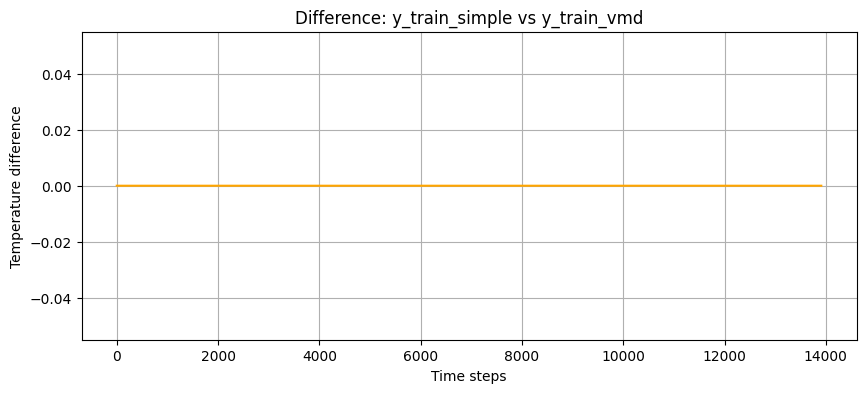

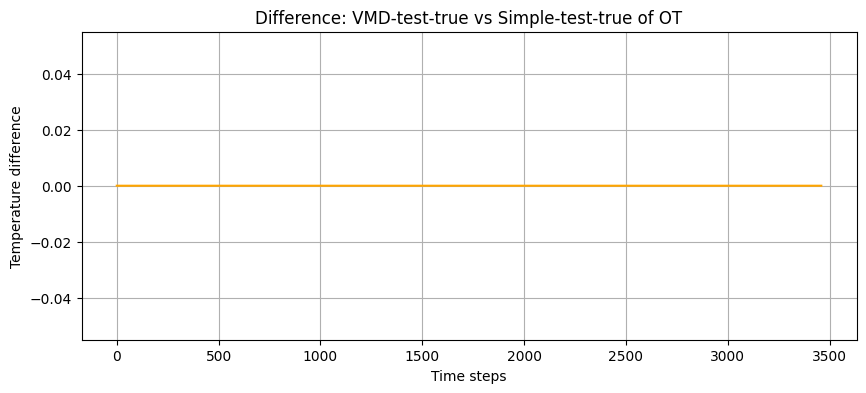

In [35]:
diff = y_train_simple_scaled - y_train_vmd_scaled
plt.figure(figsize=(10,4))
plt.plot(diff, color='orange')
plt.title('Difference: y_train_simple vs y_train_vmd')
plt.xlabel('Time steps')
plt.ylabel('Temperature difference')
plt.grid(True)
plt.show()

y_test_vmd_true = scaler_y.inverse_transform(y_test_vmd_scaled)
y_test_simple_true = scaler_y.inverse_transform(y_test_simple_scaled)
diff = y_test_simple_true - y_test_vmd_true
plt.figure(figsize=(10,4))
plt.plot(diff, color='orange')
plt.title('Difference: VMD-test-true vs Simple-test-true of OT')
plt.xlabel('Time steps')
plt.ylabel('Temperature difference')
plt.grid(True)
plt.show()